In [110]:
import sqlite3
import pandas as pd

# Connecting to the database
conn = sqlite3.connect('/Users/diboshbaruah/Desktop/Database.db')
data = pd.read_sql_query('SELECT * FROM Supermarket_data', conn)

print("Dataset successfully loaded...\n")
# Display the first few rows to inspect the data
print("Displaying first few rows of the dataset:\n")
print(data.head())

# Checking data types before conversion
print("\nData types before conversion:")
print(data.dtypes)

# Closing the connection
conn.close()


Dataset successfully loaded...

Displaying first few rows of the dataset:

   order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   1253241   152060             6          1                 20   
1   3058717    44755             2          1                 15   
2   2252307   169119            12          4                 15   
3    188072   162421             3          4                 11   
4   2627597   172693            19          0                 23   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                    23.0         115                  2          1   
1                    30.0          37                  4          0   
2                     9.0         123                 19          0   
3                    30.0         117                  5          0   
4                     5.0          17                  8          0   

   department_id department                   product_name  
0              7  beverages 

In [112]:
# Check for missing values in the scaled data
missing_values = data.isnull().sum()

# Display the number of missing values for each column
print("Missing values in each column:\n")
print(missing_values)


Missing values in each column:

order_id                      0
user_id                       0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    61437
product_id                    0
add_to_cart_order             0
reordered                     0
department_id                 0
department                    0
product_name                  0
dtype: int64


In [114]:
# Fill missing values in 'days_since_prior_order' with the median
data['days_since_prior_order'] = data['days_since_prior_order'].fillna(data['days_since_prior_order'].median())

# Check if there are any missing values left
missing_values = data.isnull().sum()

# Display the number of missing values for each column
print("\nMissing values in each column after filling:\n")
print(missing_values)



Missing values in each column after filling:

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
product_name              0
dtype: int64


In [116]:
# Drop the 'order_id' column
data_cleaned = data.drop(columns=['order_id'])


In [118]:
from sklearn.preprocessing import MinMaxScaler

# Convert the boolean columns (one-hot encoded) to integers (0 or 1)
binary_columns = data_cleaned.select_dtypes(include=['bool']).columns
data_cleaned[binary_columns] = data_cleaned[binary_columns].astype(int)

# Identify the numerical columns (which are int or float, but excluding the ones that were converted to int from bool)
numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling only to the continuous numerical columns
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])


In [120]:
# Aggregate data by customer (user_id)
aggregated_data = data_cleaned.groupby('user_id').agg({
    'order_number': 'max',  # Max order number indicates total orders made
    'days_since_prior_order': 'mean',  # Average time between orders
    'add_to_cart_order': 'mean',  # Average cart size
    'reordered': 'mean',  # Proportion of reorders
}).reset_index()

# Optionally, add the number of unique products purchased by each customer
aggregated_data['unique_products'] = data_cleaned.groupby('user_id')['product_id'].nunique().values

# Display the first few rows of the aggregated data
print("\nAggregated data per customer:\n")
print(aggregated_data.head())



Aggregated data per customer:

    user_id  order_number  days_since_prior_order  add_to_cart_order  \
0  0.000000      0.020202                0.266667           0.014706   
1  0.000005      0.101010                0.388889           0.022059   
2  0.000024      0.020202                1.000000           0.075630   
3  0.000039      0.030303                0.466667           0.106900   
4  0.000044      0.040404                1.000000           0.044118   

   reordered  unique_products  
0   0.285714                4  
1   0.333333                8  
2   0.785714               12  
3   0.230769                8  
4   0.375000                7  



First few rows after DBSCAN clustering:
    user_id  order_number  days_since_prior_order  add_to_cart_order  \
0  0.000000      0.020202                0.266667           0.014706   
1  0.000005      0.101010                0.388889           0.022059   
2  0.000024      0.020202                1.000000           0.075630   
3  0.000039      0.030303                0.466667           0.106900   
4  0.000044      0.040404                1.000000           0.044118   

   reordered  unique_products  cluster  
0   0.285714                4        0  
1   0.333333                8        1  
2   0.785714               12        2  
3   0.230769                8        1  
4   0.375000                7        3  
Silhouette Score: 0.5024030725347061


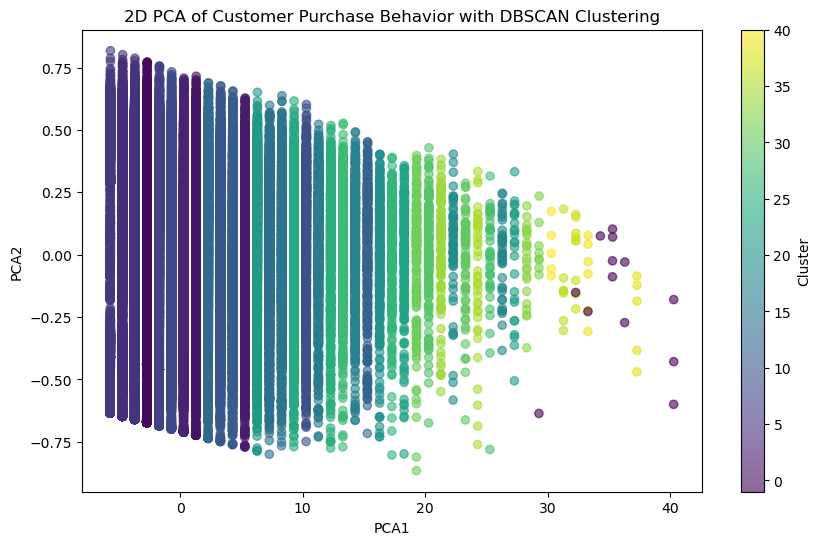

In [122]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Drop 'user_id' column as it is not needed for clustering
X = aggregated_data.drop(columns=['user_id'])

# Define the DBSCAN model (You can experiment with different values for 'eps' and 'min_samples')
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Example values for eps and min_samples

# Fit the model
aggregated_data['cluster'] = dbscan.fit_predict(X)

# View the first few rows with cluster labels
print("\nFirst few rows after DBSCAN clustering:")
print(aggregated_data.head())

# Calculate silhouette score (only for points that are not noise, i.e., label != -1)
mask = aggregated_data['cluster'] != -1  # Mask for noise points (label -1)
sil_score = silhouette_score(X[mask], aggregated_data.loc[mask, 'cluster'])
print(f"Silhouette Score: {sil_score}")

# Visualize the clusters using PCA for dimensionality reduction to 2D
from sklearn.decomposition import PCA

# Perform PCA to reduce the data to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

# Create a DataFrame with PCA components and the assigned clusters
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = aggregated_data['cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_df['PCA1'], reduced_df['PCA2'], c=reduced_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('2D PCA of Customer Purchase Behavior with DBSCAN Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()
